In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, classification_report
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFECV

import xgboost as xgb

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [2]:
def feature_importance(X, y, model_instance, feature_names, fi_name):
    #takes in features (X) and classess (y), model, column names for features in X, and name of attribute for feature importance
    #returns dictionary of feature names and coef/feature importance values
    
    feature_importance_dic = {}
    
    model_instance.fit(X, y)
    
    if fi_name == 'coef':
        coef = model_instance.coef_[0]
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'feature_importance':
        coef = model_instance.feature_importances_
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'none':
        coef = np.zeros(len(feature_names))
        feature_importance_dic = dict(zip(feature_names, coef))
    
    return feature_importance_dic

In [3]:
def classification_pipeline(X, y, cv_instance, model_instance, feature_names, fi_name):
    
    #scale data
    data_scaled = scaler.fit_transform(X)
    
    #generate cross-val sets
    cv = list(cv_instance.split(data_scaled, y))
    
    #predict class and predict probability 
    y_pred = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict')
    y_pred_prob = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict_proba')
    
    #generate confusion matrix
    conf_mat = confusion_matrix(y, y_pred)
    print('Confusion matrix:', conf_mat)
    
    #generate ROC_AUC
    ROC_AUC = metrics.roc_auc_score(y, y_pred_prob[:,1])
    print("ROC_AUC: ", ROC_AUC)
    
    # generate additional metrics
    recall = metrics.recall_score(y,y_pred)
    precision = metrics.precision_score(y,y_pred)
    accuracy = metrics.accuracy_score(y,y_pred)
    F1 = metrics.f1_score(y,y_pred)
    print("Sensitivity/Recall (TPR): ",recall)
    print("Precision (PPV): ", precision)
    print("Accuracy: ", accuracy)
    print("F1:", F1)
    
    #determine feature importance
    feature_dic = feature_importance(data_scaled, y, model_instance, feature_names, fi_name)
    
    #create dic
    data_dic = {}
    data_dic['y_pred'] = y_pred
    data_dic['y_pred_prob'] = y_pred_prob
    data_dic['conf_mat'] = conf_mat
    data_dic['ROC_AUC'] = ROC_AUC
    data_dic['recall'] = recall
    data_dic['precision'] = precision
    data_dic['accuracy'] = accuracy
    data_dic['F1'] = F1
    
    data_dic = {**data_dic, **feature_dic}
    
    return data_dic

In [4]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe, model_name):
    preds = []
    for index, row in dataframe.iterrows():

        if (row['Group'] == 0) & (row[model_name] == 0):
            pred = 'TN'
        if (row['Group'] == 0) & (row[model_name] == 1):
            pred = 'FP'
        if (row['Group'] == 1) & (row[model_name] == 1):
            pred = 'TP'
        if (row['Group'] == 1) & (row[model_name] == 0):
            pred = 'FN'
          
        preds.append(pred)
      
    dataframe[str('pred_' + model_name)] = preds
    return dataframe

### Preprocess data

In [5]:
path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Phillips/Combined.xlsx'

In [6]:
#excel file containing multiple sheets with rat cocaine self administration data (day 1 of training through reaching criteria)
#original file has multiple sheets (for different feature types) - most sheets have multiple days (columns) of training data
#use first five days and last five days of training as feature data (6 different self administration parameters to use)
#singe data point of days to criterion - use also

whole_file = pd.ExcelFile(path)

print(whole_file.sheet_names)

combined_data = pd.DataFrame()

for sheet_name in whole_file.sheet_names:
    print(sheet_name)

    if sheet_name != 'days2crit':
        
        sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name, header=None))
        sheet_data.rename({0: 'Group', 1: 'Animal'}, inplace=True, axis=1)
        sheet_data = sheet_data[['Group', 'Animal', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
           16, 17, 18, 19, 20, 21, 22, 23]]

        for index, row in sheet_data.iterrows():
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_5')] = row.dropna()[-5]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_4')] = row.dropna()[-4]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_3')] = row.dropna()[-3]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_2')] = row.dropna()[-2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_1')] = row.dropna()[-1]
            
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus1')] = row.dropna()[2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus2')] = row.dropna()[3]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus3')] = row.dropna()[4]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus4')] = row.dropna()[5]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus5')] = row.dropna()[6]
            
        sheet_data = sheet_data[['Animal', 'Group', 
                                 str(sheet_name + '_plus1'), \
                                str(sheet_name + '_plus2'), \
                                str(sheet_name + '_plus3'), \
                                str(sheet_name + '_plus4'), \
                                str(sheet_name + '_plus5'), \
                                 str(sheet_name + '_minus_5'), \
                                str(sheet_name + '_minus_4'), \
                                str(sheet_name + '_minus_3'), \
                                str(sheet_name + '_minus_2'), \
                                str(sheet_name + '_minus_1')]]
        
        sheet_data[str(sheet_name + '_last_ave')] = sheet_data.loc[:, str(sheet_name + '_minus_5'): str(sheet_name + '_minus_1')].mean(axis=1)
        sheet_data[str(sheet_name + '_first_ave')] = sheet_data.loc[:, str(sheet_name + '_plus1'): str(sheet_name + '_plus5')].mean(axis=1)
    
    if sheet_name == 'days2crit':
        sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name, header=None))
        sheet_data.rename({0: 'Group', 1: 'Animal'}, inplace=True, axis=1)
        sheet_data = sheet_data[['Group', 'Animal', 2]]
    
    if combined_data.shape[0] == 0:
        combined_data = sheet_data
    else:
        combined_data = pd.merge(combined_data, sheet_data, how='inner', on=['Animal', 'Group'], suffixes=(sheet_name, sheet_name))

combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
combined_data.rename({2:'days2crit'}, axis=1, inplace=True)
combined_data.head(1)

['actnp', 'Inactnp', 'actTO', 'avgIII', 'inactTO', 'days2crit', 'lat2fir']
actnp
Inactnp
actTO
avgIII
inactTO
days2crit
lat2fir
(80, 75)


,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_last_ave,lat2fir_first_ave
0,2223,1,8.0,17.0,15.0,23.0,19.0,27.0,20.0,21.0,7.0,19.0,18.8,16.4,8.0,10.0,5.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.6,2.0,9.0,1.0,3.0,3.0,4.0,3.0,1.0,3.0,3.0,2.8,3.6,433.69429,215.425,241.95429,156.70045,198.64611,130.57462,182.12895,170.5415,202.24412,189.33389,174.964616,249.284028,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,4,68.11,73.63,85.62,42.51,10.25,31.86,77.88,26.81,2640.67,75.58,570.56,56.024


In [7]:
combined_data['Group'] = combined_data['Group'].replace({1:1, 2:0})
combined_data['Group'].value_counts()

0    54
1    26
Name: Group, dtype: int64

### Manual feature selection and model training evaluation

In [8]:
corr = combined_data[['Group','actnp_first_ave',
                     'Inactnp_first_ave',
               'actTO_first_ave', 
                'avgIII_first_ave',
                     'inactTO_first_ave',
                     'lat2fir_first_ave',
                    'actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
                     'lat2fir_last_ave',
                     'days2crit']].corr()
corr['Group'].sort_values()

actnp_last_ave      -0.456604
actnp_first_ave     -0.312006
actTO_last_ave      -0.235893
actTO_first_ave     -0.218764
Inactnp_last_ave    -0.185934
inactTO_first_ave   -0.078286
inactTO_last_ave    -0.050435
lat2fir_last_ave    -0.038895
Inactnp_first_ave    0.042428
lat2fir_first_ave    0.132765
days2crit            0.172686
avgIII_first_ave     0.174101
avgIII_last_ave      0.299862
Group                1.000000
Name: Group, dtype: float64

In [41]:
features_full = ['actnp_plus1', 'actnp_plus2', 'actnp_plus3',
       'actnp_plus4', 'actnp_plus5', 'actnp_minus_5', 'actnp_minus_4',
       'actnp_minus_3', 'actnp_minus_2', 'actnp_minus_1', 'Inactnp_plus1',
       'Inactnp_plus2', 'Inactnp_plus3', 'Inactnp_plus4', 'Inactnp_plus5',
       'Inactnp_minus_5', 'Inactnp_minus_4', 'Inactnp_minus_3',
       'Inactnp_minus_2', 'Inactnp_minus_1', 
       'actTO_plus1', 'actTO_plus2', 'actTO_plus3', 'actTO_plus4',
       'actTO_plus5', 'actTO_minus_5', 'actTO_minus_4', 'actTO_minus_3',
       'actTO_minus_2', 'actTO_minus_1', 'avgIII_plus1',
       'avgIII_plus2', 'avgIII_plus3', 'avgIII_plus4', 'avgIII_plus5',
       'avgIII_minus_5', 'avgIII_minus_4', 'avgIII_minus_3',
       'avgIII_minus_2', 'avgIII_minus_1', 'inactTO_plus1',
       'inactTO_plus2', 'inactTO_plus3', 'inactTO_plus4', 'inactTO_plus5',
       'inactTO_minus_5', 'inactTO_minus_4', 'inactTO_minus_3',
       'inactTO_minus_2', 'inactTO_minus_1', 
       'days2crit', 'lat2fir_plus1', 'lat2fir_plus2', 'lat2fir_plus3',
       'lat2fir_plus4', 'lat2fir_plus5', 'lat2fir_minus_5',
       'lat2fir_minus_4', 'lat2fir_minus_3', 'lat2fir_minus_2',
       'lat2fir_minus_1']

features_part = ['actnp_plus1', 'actnp_plus2', 'actnp_plus3',
       'actnp_plus4', 'actnp_plus5', 'actnp_minus_5', 'actnp_minus_4',
       'actnp_minus_3', 'actnp_minus_2', 'actnp_minus_1', 
       'actTO_plus1', 'actTO_plus2', 'actTO_plus3', 'actTO_plus4',
       'actTO_plus5', 'actTO_minus_5', 'actTO_minus_4', 'actTO_minus_3',
       'actTO_minus_2', 'actTO_minus_1', 'avgIII_plus1',
       'avgIII_plus2', 'avgIII_plus3', 'avgIII_plus4', 'avgIII_plus5',
       'avgIII_minus_5', 'avgIII_minus_4', 'avgIII_minus_3',
       'avgIII_minus_2', 'avgIII_minus_1']

features_ave_part = ['actnp_first_ave',
                     'actnp_last_ave',
                     'actTO_first_ave', 
                     'actTO_last_ave']

features_ave_last = ['actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave']

all_ave = ['actnp_first_ave',
 'Inactnp_first_ave',
               'actTO_first_ave', 
                'avgIII_first_ave',
                     'inactTO_first_ave',
                     'lat2fir_first_ave',
                    'actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
                     'lat2fir_last_ave',
          'days2crit']


actnp_first_ave


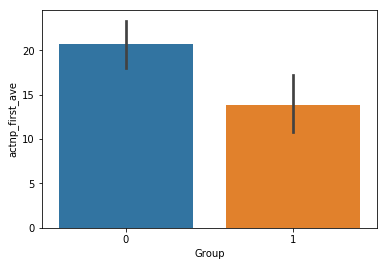

Inactnp_first_ave


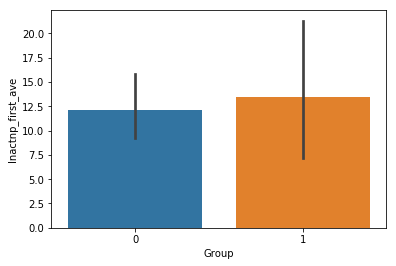

actTO_first_ave


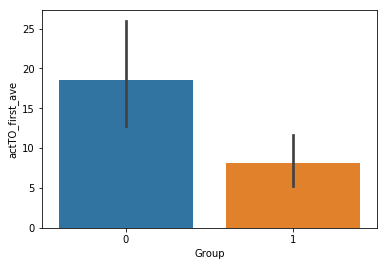

avgIII_first_ave


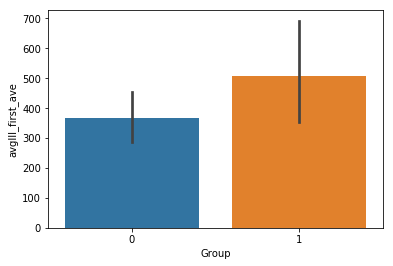

inactTO_first_ave


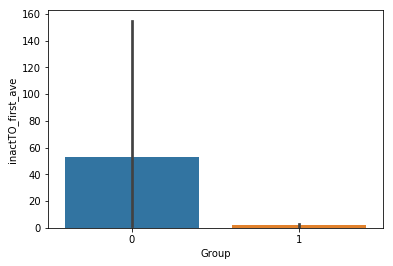

lat2fir_first_ave


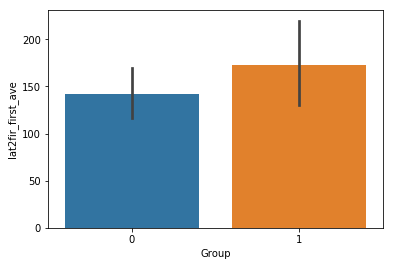

actnp_last_ave


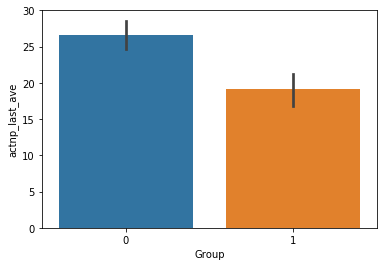

Inactnp_last_ave


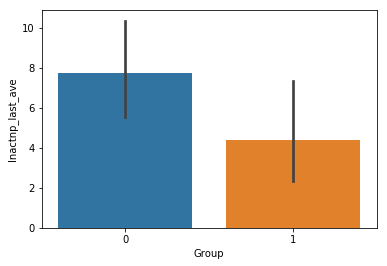

actTO_last_ave


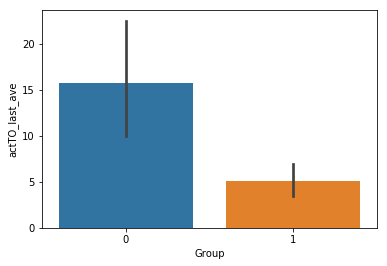

avgIII_last_ave


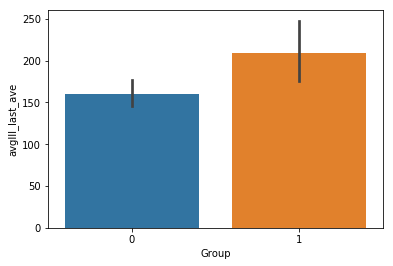

inactTO_last_ave


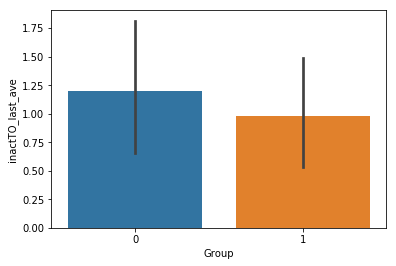

lat2fir_last_ave


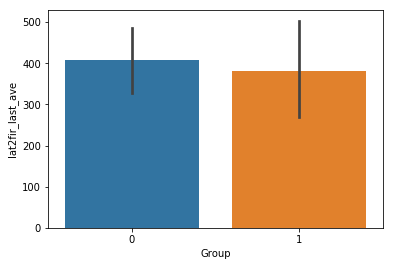

days2crit


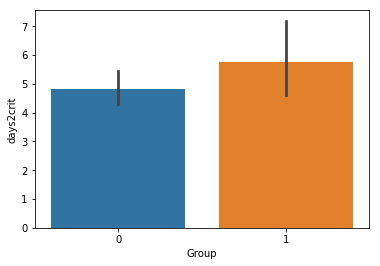

In [42]:
for param in all_ave:
    print(param)
    sns.barplot(x=combined_data["Group"], y=combined_data[param])
    plt.show()

In [43]:
#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_full = train[features_full]
X_train_part = train[features_part]
X_train_ave_part = train[features_ave_part]
X_train_ave_last = train[features_ave_last]
X_train_ave_full = train[all_ave]

X_test_full = test[features_full]
X_test_part = test[features_part]
X_test_ave_part = test[features_ave_part]
X_test_ave_last = test[features_ave_last]
X_test_ave_full = test[all_ave]

In [44]:
#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=3)

#classifier algos
dm_cv = DummyClassifier(strategy='stratified', random_state=39)
lr_cv = LogisticRegression(random_state=39, class_weight='balanced')
rf_cv = RandomForestClassifier(random_state=39, class_weight='balanced')
svm_cv = SVC(kernel='linear', probability=True, class_weight='balanced') 
knn_cv = KNeighborsClassifier()
gb_cv = GradientBoostingClassifier(random_state=39)

#dic with classifier and feature importance attribute name
models_dic = {'dm_cv': (dm_cv, 'none'), 'lr_cv': (lr_cv, 'coef'), 'rf_cv': (rf_cv, 'feature_importance'), 'svm_cv':(svm_cv, 'coef'), 'knn_cv': (knn_cv, 'none'), 'gb_cv': (gb_cv, 'feature_importance')}

In [45]:
feature_set = 'full'
feature_names = features_full

data_full_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_full_features[name + '_' + feature_set] = classification_pipeline(X_train_full, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with full features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with full features:
Confusion matrix: [[25 13]
 [ 4 14]]
ROC_AUC:  0.7646198830409356
Sensitivity/Recall (TPR):  0.7777777777777778
Precision (PPV):  0.5185185185185185
Accuracy:  0.6964285714285714
F1: 0.6222222222222222


rf_cv model with full features:
Confusion matrix: [[34  4]
 [14  4]]
ROC_AUC:  0.6527777777777778
Sensitivity/Recall (TPR):  0.2222222222222222
Precision (PPV):  0.5
Accuracy:  0.6785714285714286
F1: 0.30769230769230765


svm_cv model with full features:
Confusion matrix: [[29  9]
 [ 7 11]]
ROC_AUC:  0.7551169590643275
Sensitivity/Recall (TPR):  0.6111111111111112
Precision (PPV):  0.55
Accuracy:  0.7142857142857143
F1: 0.5789473684210527


knn_cv model with full features:
Confusion matrix: [[34  4]
 [14  4]]
ROC_AUC:  0.56505847953216

In [46]:
feature_set = 'part'
feature_names = features_part

data_part_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_part_features[name + '_' + feature_set] = classification_pipeline(X_train_part, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with part features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with part features:
Confusion matrix: [[19 19]
 [ 8 10]]
ROC_AUC:  0.5716374269005848
Sensitivity/Recall (TPR):  0.5555555555555556
Precision (PPV):  0.3448275862068966
Accuracy:  0.5178571428571429
F1: 0.4255319148936171


rf_cv model with part features:
Confusion matrix: [[35  3]
 [15  3]]
ROC_AUC:  0.6133040935672515
Sensitivity/Recall (TPR):  0.16666666666666666
Precision (PPV):  0.5
Accuracy:  0.6785714285714286
F1: 0.25


svm_cv model with part features:
Confusion matrix: [[25 13]
 [ 8 10]]
ROC_AUC:  0.6096491228070176
Sensitivity/Recall (TPR):  0.5555555555555556
Precision (PPV):  0.43478260869565216
Accuracy:  0.625
F1: 0.4878048780487805


knn_cv model with part features:
Confusion matrix: [[23 15]
 [12  6]]
ROC_AUC:  0.47514619883040937
Sensitiv

In [47]:
feature_set = 'ave_part'
feature_names = features_ave_part

data_ave_part_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_ave_part_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_part, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with ave_part features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with ave_part features:
Confusion matrix: [[26 12]
 [ 4 14]]
ROC_AUC:  0.7792397660818713
Sensitivity/Recall (TPR):  0.7777777777777778
Precision (PPV):  0.5384615384615384
Accuracy:  0.7142857142857143
F1: 0.6363636363636364


rf_cv model with ave_part features:
Confusion matrix: [[31  7]
 [15  3]]
ROC_AUC:  0.6564327485380117
Sensitivity/Recall (TPR):  0.16666666666666666
Precision (PPV):  0.3
Accuracy:  0.6071428571428571
F1: 0.21428571428571427


svm_cv model with ave_part features:
Confusion matrix: [[25 13]
 [ 3 15]]
ROC_AUC:  0.7733918128654971
Sensitivity/Recall (TPR):  0.8333333333333334
Precision (PPV):  0.5357142857142857
Accuracy:  0.7142857142857143
F1: 0.6521739130434783


knn_cv model with ave_part features:
Confusion matrix: [[31  7]
 

In [48]:
feature_set = 'ave_last'
feature_names = features_ave_last

data_ave_last_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_ave_last_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_last, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with ave_last features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with ave_last features:
Confusion matrix: [[26 12]
 [ 4 14]]
ROC_AUC:  0.7558479532163743
Sensitivity/Recall (TPR):  0.7777777777777778
Precision (PPV):  0.5384615384615384
Accuracy:  0.7142857142857143
F1: 0.6363636363636364


rf_cv model with ave_last features:
Confusion matrix: [[32  6]
 [10  8]]
ROC_AUC:  0.7207602339181287
Sensitivity/Recall (TPR):  0.4444444444444444
Precision (PPV):  0.5714285714285714
Accuracy:  0.7142857142857143
F1: 0.5


svm_cv model with ave_last features:
Confusion matrix: [[24 14]
 [ 3 15]]
ROC_AUC:  0.7719298245614036
Sensitivity/Recall (TPR):  0.8333333333333334
Precision (PPV):  0.5172413793103449
Accuracy:  0.6964285714285714
F1: 0.6382978723404256


knn_cv model with ave_last features:
Confusion matrix: [[27 11]
 [1

In [49]:
#put dics in pandas df 
final_dic = {**data_full_features, **data_part_features, **data_ave_part_features, **data_ave_last_features}
data_pandas = pd.DataFrame.from_dict(data = final_dic, orient='index')
data_pandas.sort_values('F1', ascending=False).head()

,y_pred,y_pred_prob,conf_mat,ROC_AUC,recall,precision,accuracy,F1,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,actnp_first_ave,actnp_last_ave,actTO_first_ave,actTO_last_ave,Inactnp_last_ave,avgIII_last_ave
svm_cv_ave_part,"[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...","[[0.252032869699381, 0.7479671303006192], [0.8...","[[25, 13], [3, 15]]",0.773392,0.833333,0.535714,0.714286,0.652174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.491782,-1.418020,-0.051806,0.004137,NaN,NaN
svm_cv_ave_last,"[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...","[[0.22448519447696777, 0.7755148055230323], [0...","[[24, 14], [3, 15]]",0.771930,0.833333,0.517241,0.696429,0.638298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.729572,NaN,-0.127044,-0.97370,-0.297803
lr_cv_ave_last,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...","[[0.014221467842337576, 0.9857785321576624], [...","[[26, 12], [4, 14]]",0.755848,0.777778,0.538462,0.714286,0.636364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.511737,NaN,-0.365279,-0.71737,-0.143010
lr_cv_ave_part,"[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...","[[0.11332948164384604, 0.886670518356154], [0....","[[26, 12], [4, 14]]",0.779240,0.777778,0.538462,0.714286,0.636364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.255127,-1.233734,-0.233297,-0.366309,NaN,NaN
lr_cv_full,"[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, ...","[[0.14120767146030788, 0.8587923285396921], [0...","[[25, 13], [4, 14]]",0.764620,0.777778,0.518519,0.696429,0.622222,-0.150361,-0.120353,-0.433793,-0.222793,-0.081994,-0.570863,-0.787316,-0.04652,-0.619513,-0.259363,0.202226,0.572503,-0.004297,-0.316742,0.253398,-0.130099,-0.953071,-0.115522,-0.02988,-0.333819,0.104418,-0.076695,-0.147118,-0.182309,0.111684,-0.33541,0.09231,0.112612,-0.022004,0.266086,-0.092933,-0.23697,0.27479,-0.006972,0.17143,0.379707,-0.324484,0.21575,-0.182645,0.162229,-0.040093,0.102492,0.000354,0.57803,0.449687,0.092777,-0.107164,-0.256377,0.959416,-0.034386,0.033685,0.363036,0.536796,0.742872,0.08722,0.105578,-0.266749,-0.516761,0.483198,0.584524,-0.368227,NaN,NaN,NaN,NaN,NaN,NaN


Text(0,0.5,'True Positive Rate (Sensitivity)')

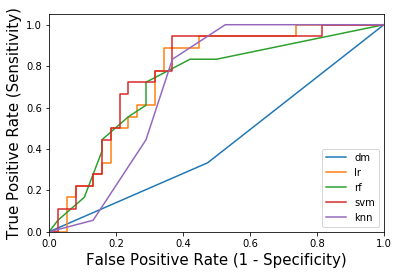

In [50]:
fpr_dm, tpr_dm, thresholds_dm = metrics.roc_curve(Y_train_class, data_ave_last_features['dm_cv_ave_last']['y_pred_prob'][:,1])
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(Y_train_class, data_ave_last_features['lr_cv_ave_last']['y_pred_prob'][:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(Y_train_class, data_ave_last_features['rf_cv_ave_last']['y_pred_prob'][:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(Y_train_class, data_ave_last_features['svm_cv_ave_last']['y_pred_prob'][:,1])
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(Y_train_class, data_ave_last_features['knn_cv_ave_last']['y_pred_prob'][:,1])

# plot model ROC curves
plt.plot(fpr_dm, tpr_dm, label="dm")
plt.plot(fpr_lr, tpr_lr, label="lr")
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_knn, tpr_knn, label="knn")

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0,0.5,'Precision')

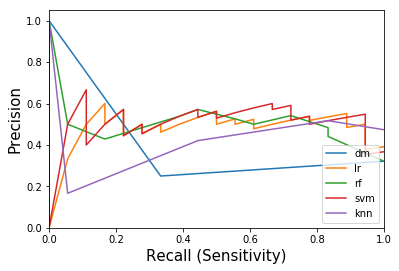

In [51]:
# calculate precision-recall curve
precision_dm, recall_dm, thresholds_pr_dm = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['dm_cv_ave_last']['y_pred_prob'][:,1])
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['lr_cv_ave_last']['y_pred_prob'][:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['rf_cv_ave_last']['y_pred_prob'][:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['svm_cv_ave_last']['y_pred_prob'][:,1])
precision_knn, recall_knn, thresholds_pr_knn = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['knn_cv_ave_last']['y_pred_prob'][:,1])

plt.plot(recall_dm, precision_dm, label='dm')
plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')
plt.plot(recall_knn, precision_knn, label='knn')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

In [52]:
#scale data for grid search
ave_last_scaled = scaler.fit_transform(X_train_ave_last)

#grid search with cv for svm and ave last features
param_grid = {'C':(0.001, 0.01, 0.1, 1, 10), 'decision_function_shape':('ovo','ovr')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

svm_base = SVC(kernel='linear', class_weight='balanced', random_state=39)

svm_gs = GridSearchCV(svm_base, param_grid, cv=3, scoring = scoring, refit='f1')
svm_gs.fit(ave_last_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(svm_gs, ave_last_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_gs, ave_last_scaled, Y_train_class, scoring='roc_auc'))))

print(svm_gs.best_params_)

f1:0.7105263157894736
ROC_AUC:0.8059116809116809
{'C': 0.1, 'decision_function_shape': 'ovo'}


In [53]:
#use best params

svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', C=.1, decision_function_shape='ovo', random_state=39)
    
print("f1:"+str(np.average(cross_val_score(svm_best, ave_last_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_best, ave_last_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(svm_best, ave_last_scaled, Y_train_class, scoring='accuracy'))))

svm_best.fit(ave_last_scaled, Y_train_class)
print(svm_best.score(ave_last_scaled, Y_train_class))

train_pred_svm = svm_best.predict(ave_last_scaled)
train_pred_prob_svm = svm_best.predict_proba(ave_last_scaled)
print(classification_report(Y_train_class, train_pred_svm))
print(confusion_matrix(Y_train_class, train_pred_svm))

f1:0.7105263157894736
ROC_AUC:0.8059116809116809
Accuracy:0.732943469785575
0.75
              precision    recall  f1-score   support

           0       0.96      0.66      0.78        38
           1       0.57      0.94      0.71        18

   micro avg       0.75      0.75      0.75        56
   macro avg       0.76      0.80      0.74        56
weighted avg       0.83      0.75      0.76        56

[[25 13]
 [ 1 17]]


In [54]:
#create new columns for each model's pred prob and the best model's pred class
train['class_svm'] = train_pred_svm
train['pred_prob_svm'] = train_pred_prob_svm[:,1]

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_svm'
train = conf_mat_column(train, model_name)
train.head()

,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_last_ave,lat2fir_first_ave,class_svm,pred_prob_svm,pred_class_svm
40,2384,0,6.0,6.0,6.0,10.0,18.0,18.0,3.0,16.0,21.0,5.0,12.6,9.2,7.0,7.0,4.0,14.0,9.0,1.0,9.0,1.0,0.0,0.0,2.2,8.2,8.0,7.0,3.0,15.0,15.0,1.0,1.0,0.0,2.0,0.0,0.8,9.6,577.566000,642.332000,701.454000,370.240000,202.590588,197.956471,1299.025000,225.739333,185.679545,291.704167,440.020903,498.836518,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,6,679.57,88.48,29.88,21.85,11.67,43.65,142.71,57.89,19.06,2616.59,575.980,166.290,1,0.491708,FP
10,2398,1,9.0,39.0,23.0,37.0,28.0,37.0,28.0,28.0,26.0,15.0,26.8,27.2,5.0,11.0,16.0,8.0,1.0,1.0,0.0,0.0,3.0,3.0,1.4,8.2,0.0,18.0,3.0,26.0,5.0,5.0,0.0,4.0,5.0,5.0,3.8,10.4,392.385000,84.433947,157.314550,94.966944,126.829260,94.966944,126.829260,127.621110,138.510800,87.966471,115.178917,171.185940,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,6.0,6.0,2.4,3.6,4,449.48,343.02,34.38,33.45,23.03,33.45,23.03,27.14,27.44,2585.14,539.240,176.672,0,0.330648,FN
44,2483,0,9.0,28.0,29.0,25.0,11.0,44.0,21.0,39.0,2.0,32.0,27.6,20.4,5.0,0.0,0.0,10.0,8.0,0.0,1.0,0.0,0.0,4.0,1.0,4.6,9.0,15.0,4.0,2.0,9.0,6.0,13.0,3.0,1.0,1.0,4.8,7.8,400.177500,129.619259,121.609286,147.410833,162.872000,78.355349,154.708000,85.617632,435.242500,104.998387,171.784374,192.337776,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,3.0,1.8,0.2,4,212.79,62.54,13.68,1.75,6.77,2.68,17.04,10.62,2646.79,46.23,544.672,59.506,0,0.329898,TN
73,2854,0,7.0,13.0,29.0,37.0,22.0,22.0,35.0,43.0,18.0,33.0,30.2,21.6,25.0,38.0,12.0,14.0,5.0,5.0,5.0,51.0,14.0,32.0,21.4,18.8,11.0,8.0,67.0,23.0,7.0,7.0,9.0,17.0,10.0,15.0,11.6,23.2,515.998333,245.929167,125.652857,86.476944,160.158095,160.158095,91.617941,81.714762,171.771176,103.046562,121.661707,226.843079,0.0,0.0,8.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,0.8,2.4,4,14.48,213.09,56.57,13.61,187.42,187.42,13.98,54.52,313.75,65.97,127.128,97.034,0,0.237694,TN
52,2533,0,30.0,3.0,8.0,30.0,23.0,23.0,37.0,33.0,33.0,3.0,25.8,18.8,25.0,6.0,8.0,69.0,4.0,4.0,36.0,2.0,12.0,0.0,10.8,22.4,6.0,1.0,6.0,18.0,3.0,3.0,17.0,7.0,4.0,0.0,6.2,6.8,117.141724,289.860000,422.617143,113.907586,159.582273,159.582273,84.164445,109.942813,111.433125,217.844375,136.593406,220.621745,4.0,0.0,0.0,17.0,1.0,1.0,1.0,1.0,0.0,0.0,0.6,4.4,6,18.90,58.93,596.34,120.48,4.18,4.18,41.97,14.59,6.51,2692.58,551.966,159.766,0,0.306276,TN


actnp_last_ave
Inactnp_last_ave
actTO_last_ave
avgIII_last_ave
pred_prob_svm
pred_class_svm


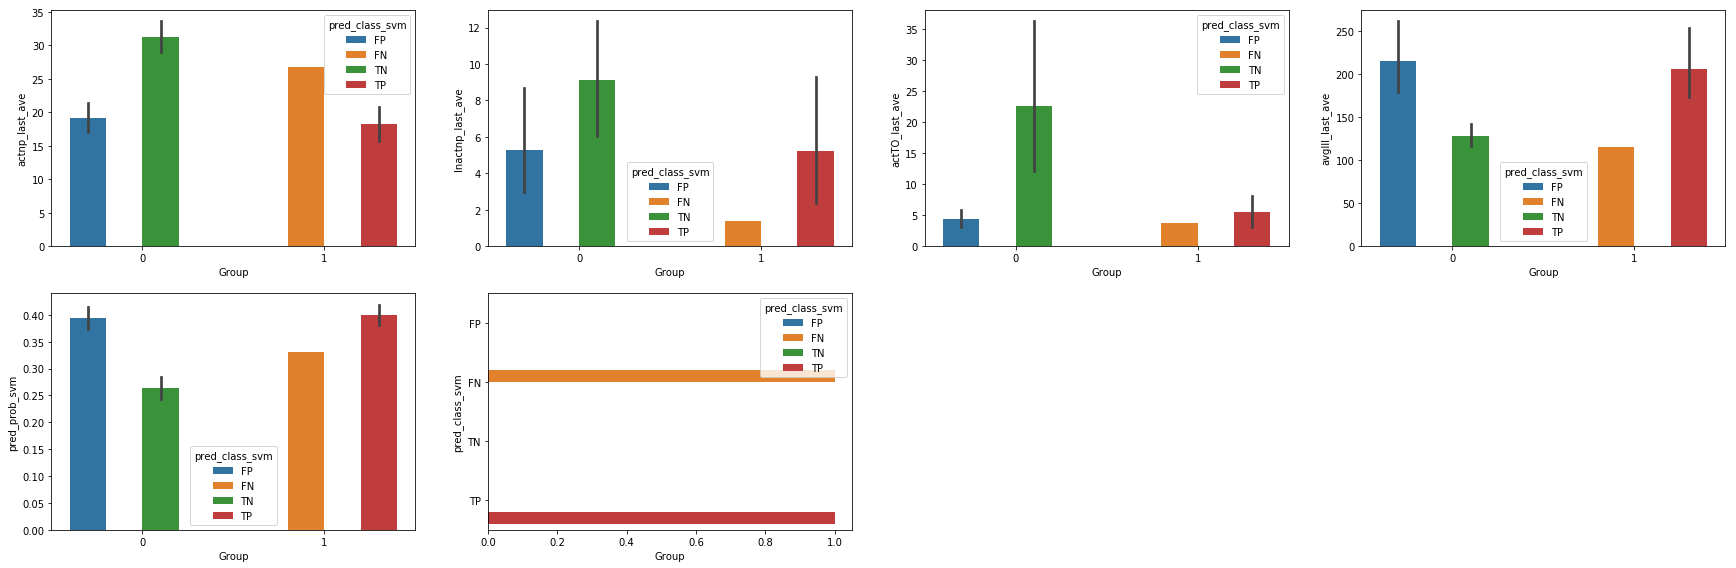

In [55]:
params = ['actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
          'pred_prob_svm',
       'pred_class_svm']

i=1
plt.figure(figsize=(30,20))
for param in params:
    print(param)
    plt.subplot(4, 4, i)
    sns.barplot(x=train["Group"], y=train[param], hue=train["pred_class_svm"])
    i = i + 1

In [56]:
#run on test data
#scale data
test_ave_last_scaled = scaler.fit_transform(X_test_ave_last)

print('SVM test AUC: {}'.format(svm_best.score(test_ave_last_scaled, Y_test_class)))
test_pred_svm = svm_best.predict(test_ave_last_scaled)
test_pred_prob_svm = svm_best.predict_proba(test_ave_last_scaled)
print(classification_report(Y_test_class, test_pred_svm))
print(confusion_matrix(Y_test_class, test_pred_svm))

SVM test AUC: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        16
           1       0.50      0.88      0.64         8

   micro avg       0.67      0.67      0.67        24
   macro avg       0.70      0.72      0.66        24
weighted avg       0.77      0.67      0.67        24

[[9 7]
 [1 7]]


In [57]:
#create new columns for each model's pred prob and the best model's pred class
test['class_svm'] = test_pred_svm
test['pred_prob_svm'] = test_pred_prob_svm[:,1]

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_svm'
test = conf_mat_column(test, model_name)
test.head()

,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_last_ave,lat2fir_first_ave,class_svm,pred_prob_svm,pred_class_svm
77,2861,0,2.0,1.0,2.0,4.0,3.0,41.0,34.0,29.0,29.0,6.0,27.8,2.4,3.0,3.0,0.0,5.0,6.0,5.0,0.0,4.0,5.0,5.0,3.8,3.4,1.0,0.0,0.0,2.0,0.0,24.0,6.0,5.0,3.0,2.0,8.0,0.6,1797.490000,1404.110000,1404.110000,837.410000,1227.110000,86.686250,105.964848,123.022143,121.323214,639.434000,215.286091,1334.046000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,957.58,292.17,99.80,34.09,261.04,2.67,0.26,28.32,47.08,14.68,18.602,328.936,0,0.293943,TN
33,2284,0,5.0,15.0,17.0,15.0,17.0,40.0,30.0,37.0,7.0,42.0,31.2,13.8,5.0,26.0,6.0,2.0,1.0,24.0,2.0,6.0,7.0,78.0,23.4,8.0,4.0,5.0,0.0,11.0,6.0,42.0,9.0,50.0,8.0,81.0,38.0,5.2,744.682500,232.832857,217.224375,218.526429,223.348750,84.617179,117.776207,96.852222,176.566111,84.597561,112.081856,327.322982,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,13.0,3.4,0.0,4,112.90,115.25,16.00,0.93,12.72,39.65,43.01,74.40,2675.06,12.33,568.890,51.560,0,0.191111,TN
20,2768,1,4.0,3.0,1.0,2.0,5.0,19.0,9.0,9.0,11.0,15.0,12.6,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.4,0.6,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,1126.416667,908.645000,1116.430000,1116.430000,639.092500,196.110556,429.833750,371.170000,305.308000,215.656429,303.615747,981.402833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,194.77,314.63,644.30,15.48,116.23,13.65,96.45,13.49,10.80,409.42,108.762,257.082,1,0.509869,TP
27,2248,0,35.0,22.0,23.0,15.0,15.0,34.0,40.0,37.0,31.0,2.0,28.8,22.0,17.0,4.0,7.0,5.0,12.0,6.0,14.0,9.0,4.0,4.0,7.4,9.0,24.0,5.0,2.0,0.0,4.0,7.0,18.0,20.0,17.0,1.0,12.6,7.0,83.435588,154.888095,159.855455,225.647857,228.227857,107.067273,88.060000,94.680833,112.040000,835.030000,247.375621,170.410970,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2,0.6,3,695.30,44.87,43.96,53.25,27.23,24.75,33.56,39.42,10.31,2673.74,556.356,172.922,0,0.273879,TN
63,2748,0,5.0,9.0,7.0,6.0,10.0,21.0,23.0,24.0,22.0,24.0,22.8,7.4,5.0,8.0,2.0,4.0,1.0,0.0,0.0,0.0,5.0,1.0,1.2,4.0,6.0,6.0,4.0,5.0,1.0,4.0,1.0,2.0,1.0,3.0,2.2,4.4,731.785000,398.102500,532.975000,638.966000,382.664445,171.705000,155.939546,153.675217,154.640000,149.006957,156.993344,536.898589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,54.27,36.26,52.59,14.78,33.97,3.46,30.20,47.12,29.55,16.24,25.314,38.374,1,0.360231,FP


actnp_last_ave
Inactnp_last_ave
actTO_last_ave
avgIII_last_ave
pred_prob_svm
pred_class_svm


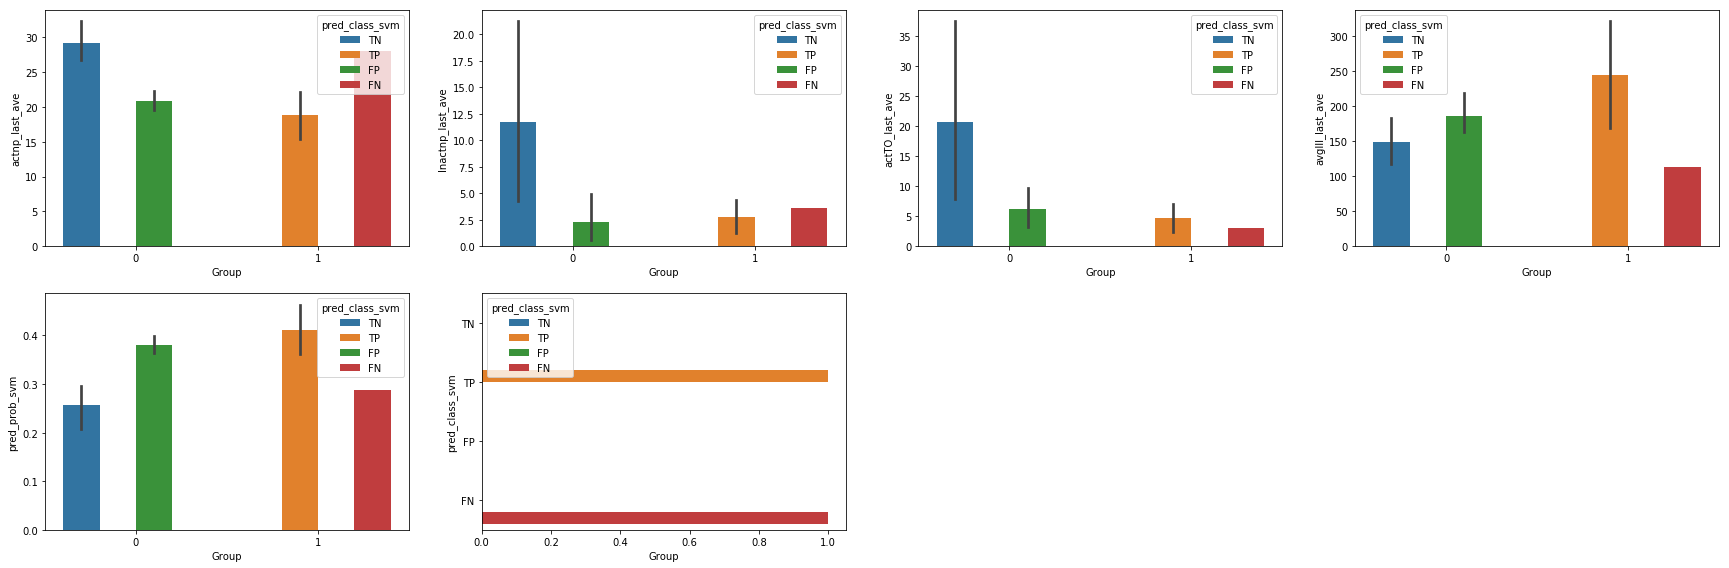

In [58]:
params = ['actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
          'pred_prob_svm',
       'pred_class_svm']

i=1
plt.figure(figsize=(30,20))
for param in params:
    print(param)
    plt.subplot(4, 4, i)
    sns.barplot(x=test["Group"], y=test[param], hue=test["pred_class_svm"])
    i = i + 1

In [59]:
test[['Animal', 'Group', 'class_svm', 'pred_prob_svm', 'pred_class_svm']].sort_values('pred_class_svm')

,Animal,Group,class_svm,pred_prob_svm,pred_class_svm
12,2540,1,0,0.287387,FN
42,2410,0,1,0.348733,FP
31,2282,0,1,0.351578,FP
37,2373,0,1,0.385102,FP
51,2530,0,1,0.404531,FP
69,2827,0,1,0.410926,FP
34,2286,0,1,0.398017,FP
63,2748,0,1,0.360231,FP
35,2340,0,0,0.291525,TN
33,2284,0,0,0.191111,TN


### Recursive feature elimination for feature selection and model training evaluation

In [ ]:
data = X_train_ave_full

#scale data
X = scaler.fit_transform(data)
y = Y_train_class

svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', decision_function_shape='ovo', random_state=39)
selector = RFECV(svm_best, step=1, cv=3)
selector = selector.fit(X, y)
feature_rankings = list(zip(data.columns.values, selector.ranking_))

print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

feature_rankings

In [ ]:
all_features = ['actnp_first_ave', 'Inactnp_first_ave', 'actTO_first_ave',
       'avgIII_first_ave', 'inactTO_first_ave', 'lat2fir_first_ave',
       'days2crit', 'actnp_last_ave', 'Inactnp_last_ave',
       'actTO_last_ave', 'avgIII_last_ave', 'inactTO_last_ave',
       'lat2fir_last_ave']

cv5_features = ['actnp_first_ave', 'Inactnp_first_ave', 'actTO_first_ave', 'lat2fir_first_ave', 'actnp_last_ave', 
                 'Inactnp_last_ave', 'avgIII_last_ave', 'inactTO_last_ave']

cv3_features = ['lat2fir_first_ave', 'actnp_last_ave', 'Inactnp_last_ave']

In [ ]:
data = cv3_features

#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_rfe = train[data]

X_test_rfe = test[data]

In [ ]:
#scale data
data_scaled = scaler.fit_transform(X_train_rfe)

#grid search with cv for svm and ave last features
param_grid = {'C':(0.001, 0.01, 0.1, 1, 10), 'decision_function_shape':('ovo','ovr')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

svm_base = SVC(kernel='linear', class_weight='balanced', random_state=39)

svm_gs = GridSearchCV(svm_base, param_grid, cv=3, scoring = scoring, refit='f1')
svm_gs.fit(data_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(svm_gs, data_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_gs, data_scaled, Y_train_class, scoring='roc_auc'))))

print(svm_gs.best_params_)

In [ ]:
svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', C=10, decision_function_shape='ovo', random_state=39)
    
print("f1:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='accuracy'))))

In [ ]:
svm_best.fit(data_scaled, Y_train_class)
print(svm_best.score(data_scaled, Y_train_class))

#scale data
data_scaled_test = scaler.fit_transform(X_test_rfe)

print('SVM test AUC: {}'.format(svm_best.score(data_scaled_test, Y_test_class)))
test_pred_svm = svm_best.predict(data_scaled_test)
test_pred_prob_svm = svm_best.predict_proba(data_scaled_test)
print(classification_report(Y_test_class, test_pred_svm))
print(confusion_matrix(Y_test_class, test_pred_svm))

### Unsupervised 

In [60]:
features_cluster = combined_data[['actnp_last_ave', 
                'Inactnp_last_ave', 
               'actTO_last_ave', 
                'avgIII_last_ave']]

# center and scale the data
scaler = StandardScaler()

features_clust_scaled = scaler.fit_transform(features_cluster)

Text(0,0.5,'Silhouette Coefficient')

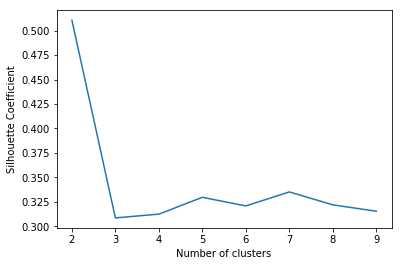

In [61]:
k_range = range(2,10)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(features_clust_scaled)
    scores.append(silhouette_score(features_clust_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [66]:
km2 = KMeans(n_clusters=2,random_state=1234)
km2.fit(features_clust_scaled)
combined_data['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
combined_data.groupby('kmeans_2_scaled').mean()

,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_last_ave,lat2fir_first_ave
kmeans_2_scaled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cluster_0,2560.507463,0.373134,11.134328,17.582090,17.477612,20.149254,20.134328,25.238806,25.343284,24.552239,19.268657,18.746269,22.629851,17.295522,10.776119,14.522388,9.611940,9.865672,10.388060,4.343284,5.044776,3.313433,4.582090,2.895522,4.035821,11.032836,7.417910,12.686567,11.014925,10.865672,8.298507,7.462687,7.835821,5.656716,4.910448,5.238806,6.220896,10.056716,619.717244,454.989680,428.227049,378.537433,263.679292,168.590886,175.023201,160.215059,234.609035,211.062896,189.900215,429.030140,1.134328,207.000000,1.567164,2.029851,1.149254,0.671642,0.641791,0.746269,0.791045,0.746269,0.719403,42.576119,5.268657,323.736567,147.555373,145.387313,86.205373,61.222537,61.146866,72.977761,93.316716,766.913284,1027.536716,404.378269,152.821433
cluster_1,2585.153846,0.076923,14.769231,22.538462,28.230769,29.230769,28.153846,37.153846,35.615385,35.615385,28.384615,24.461538,32.246154,24.584615,12.846154,21.076923,13.153846,34.846154,18.923077,31.461538,15.230769,19.692308,15.384615,18.769231,20.107692,20.169231,12.615385,12.000000,73.923077,67.461538,41.769231,46.461538,50.461538,56.615385,41.692308,22.384615,43.523077,41.553846,646.592593,285.002698,247.350161,256.196566,223.890211,95.384898,102.861340,94.749414,113.844149,117.755229,104.919006,331.806446,3.076923,2.384615,3.692308,4.769231,1.846154,4.153846,1.923077,6.076923,1.769231,2.153846,3.215385,3.153846,4.461538,418.599231,158.271538,28.002308,41.916923,86.270769,75.204615,41.187692,239.031538,657.323077,851.743846,372.898154,146.612154


In [67]:
combined_data.groupby('Group')['kmeans_2_scaled'].value_counts()

Group  kmeans_2_scaled
0      cluster_0          42
       cluster_1          12
1      cluster_0          25
       cluster_1           1
Name: kmeans_2_scaled, dtype: int64

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, random_state=1234)
tsne_features = tsne.fit_transform(features_clust_scaled)

print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = combined_data.index)
combined_data = pd.concat([combined_data, tsne_df], axis = 1)
combined_data.head()

In [ ]:
sns.pairplot(x_vars='tsne_0', y_vars='tsne_1', data=combined_data, hue='Group')
plt.show()
sns.pairplot(x_vars='tsne_0', y_vars='tsne_1', data=combined_data, hue='kmeans_2_scaled')
plt.show()